<a href="https://colab.research.google.com/github/ameyas1/GenrePrediction/blob/master/Genre_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2020-08-13 12:49:44--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M   886KB/s    in 54s     

2020-08-13 12:50:38 (874 KB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [ ]:
!tar -xzf /content/MovieSummaries.tar.gz

In [ ]:
!pip install git+https://github.com/joeddav/transformers.git@data-collator-type-fix

  Cloning https://github.com/joeddav/transformers.git (to revision data-collator-type-fix) to /tmp/pip-req-build-ryqiq61j
  Running command git clone -q https://github.com/joeddav/transformers.git /tmp/pip-req-build-ryqiq61j
  Running command git checkout -b data-collator-type-fix --track origin/data-collator-type-fix
  Switched to a new branch 'data-collator-type-fix'
  Branch 'data-collator-type-fix' set up to track remote branch 'data-collator-type-fix' from 'origin'.
     |████████████████████████████████| 3.0MB 4.7MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
  Created wheel for transformers: filename=transformers-2.11.0-cp36-none-any.whl size=746347 sha256=61cb856433acf75c385f385271adb30e0a3c2c6f51f5a5d3c2e8347c2069a123
  Stored in directory: /tmp/pip-ephem-wheel-cache-hh46h1le/wheels/17/d2/a2/c00487983b93ad7c3c487727a842b0f3ea8f7242c89fa93441
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-no

In [ ]:
import tensorflow_addons as tfa

In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
meta = pd.read_csv("/content/MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [ ]:
meta.head(3)

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [ ]:
plots = []

with open("/content/MovieSummaries/plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)
plots[:2]

42303it [00:01, 37737.27it/s]


[['23890098',
  "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."],
 ['31186339',
  'The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at speci

In [ ]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|██████████| 42303/42303 [00:00<00:00, 1441268.17it/s]


In [ ]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [ ]:
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head(3)

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."


In [ ]:
json.loads(movies['genre'][0])

{'/m/03q4nz': 'World cinema', '/m/07s9rl0': 'Drama'}

In [ ]:
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [ ]:
movies.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


In [ ]:
movies=movies[['plot','genre_new']]
movies.head()

,plot,genre_new
0,"Shlykov, a hard-working taxi driver and Lyosha...","[Drama, World cinema]"
1,The nation of Panem consists of a wealthy Capi...,"[Action/Adventure, Science Fiction, Action, Dr..."
2,Poovalli Induchoodan is sentenced for six yea...,"[Musical, Action, Drama, Bollywood]"
3,"The Lemon Drop Kid , a New York City swindler,...","[Screwball comedy, Comedy]"
4,Seventh-day Adventist Church pastor Michael Ch...,"[Crime Fiction, Drama, Docudrama, World cinema..."


In [ ]:
all_genres = sum(genres,[])

In [ ]:
all_genres[:10]

['Drama',
 'World cinema',
 'Action/Adventure',
 'Science Fiction',
 'Action',
 'Drama',
 'Musical',
 'Action',
 'Drama',
 'Bollywood']

In [ ]:
num_genres = len(set(all_genres))
num_genres

363

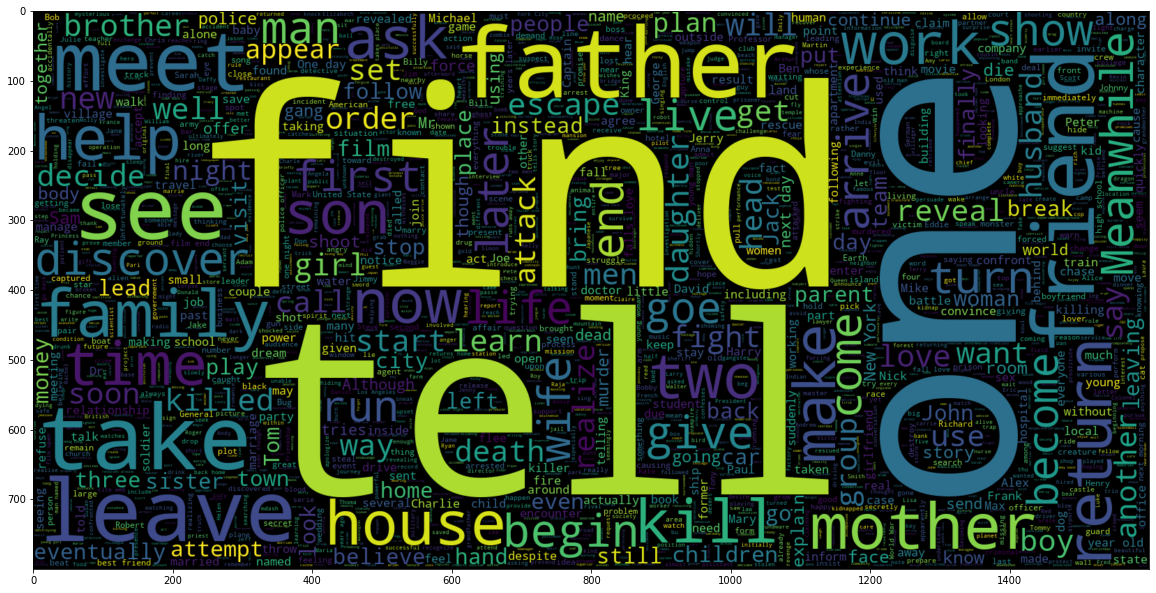

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(movies['plot']))
plt.imshow(wc, interpolation = 'bilinear')

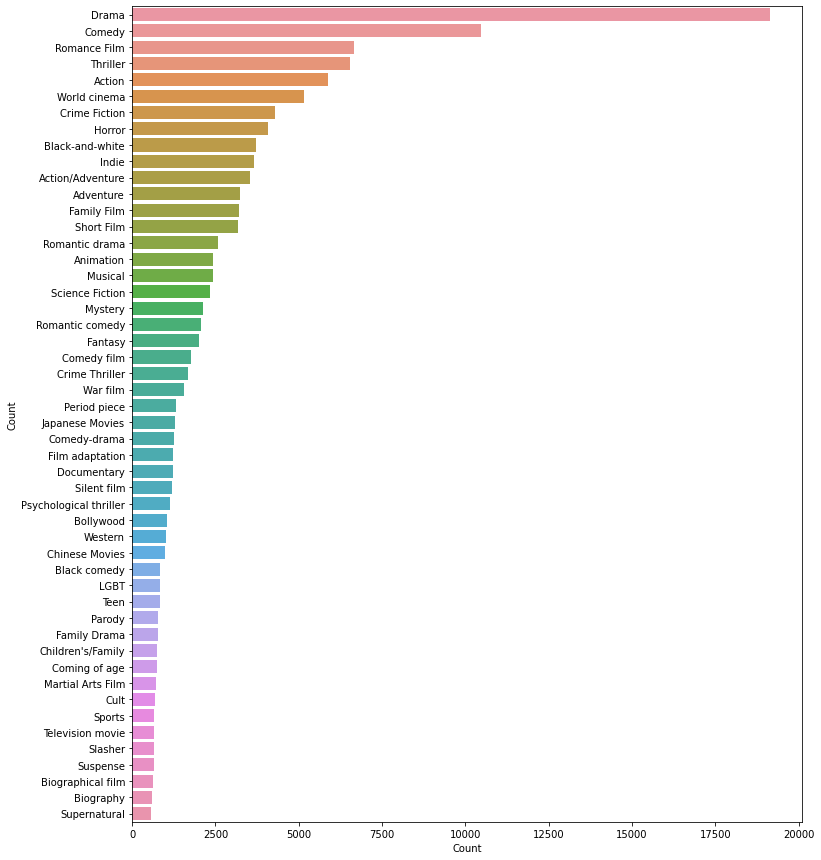

In [ ]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [ ]:
# maxi = max(all_genres.values())
# maxi

In [ ]:
# genre_weights = {}

In [ ]:
# for gen in all_genres:
#   genre_weights[gen] = maxi/all_genres[gen]

In [ ]:
# genre_weights

In [ ]:
all_genres

FreqDist({'Absurdism': 79,
          'Acid western': 7,
          'Action': 5868,
          'Action Comedy': 142,
          'Action Thrillers': 405,
          'Action/Adventure': 3553,
          'Addiction Drama': 42,
          'Adult': 117,
          'Adventure': 3248,
          'Adventure Comedy': 123,
          'Airplanes and airports': 53,
          'Albino bias': 14,
          'Alien Film': 97,
          'Alien invasion': 4,
          'Americana': 91,
          'Animal Picture': 141,
          'Animals': 15,
          'Animated Musical': 43,
          'Animated cartoon': 94,
          'Animation': 2441,
          'Anime': 305,
          'Anthology': 7,
          'Anthropology': 2,
          'Anti-war': 32,
          'Anti-war film': 31,
          'Apocalyptic and post-apocalyptic fiction': 32,
          'Archaeology': 10,
          'Archives and records': 6,
          'Art film': 351,
          'Auto racing': 50,
          'Avant-garde': 83,
          'B-Western': 19,
          'B

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies['genre_new'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
labels = multilabel_binarizer.classes_

In [ ]:
labels

array(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy', 'Airplanes and airports',
       'Albino bias', 'Alien Film', 'Alien invasion', 'Americana',
       'Animal Picture', 'Animals', 'Animated Musical',
       'Animated cartoon', 'Animation', 'Anime', 'Anthology',
       'Anthropology', 'Anti-war', 'Anti-war film',
       'Apocalyptic and post-apocalyptic fiction', 'Archaeology',
       'Archives and records', 'Art film', 'Auto racing', 'Avant-garde',
       'B-Western', 'B-movie', 'Backstage Musical', 'Baseball',
       'Beach Film', 'Beach Party film', 'Bengali Cinema', 'Biker Film',
       'Biographical film', 'Biography', 'Biopic [feature]',
       'Black comedy', 'Black-and-white', 'Blaxploitation',
       'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance',
       'British Empire Film', 'British New Wave', 'Bruceploitation',
       'Buddy Picture

In [ ]:
# genre_weights['Absurdism']

In [ ]:
# class_weights={}

# for i,gen in enumerate(multilabel_binarizer.classes_):
#   class_weights[i] = genre_weights[gen]

# class_weights

In [ ]:
y = multilabel_binarizer.transform(movies['genre_new'])

In [ ]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in movies['plot']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 5581


In [ ]:
from transformers import DistilBertTokenizerFast, TFAutoModel, TFDistilBertForSequenceClassification, DistilBertConfig,AutoTokenizer
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizerFast.from_pretrained(distil_bert)
gen_tokenizer = AutoTokenizer.from_pretrained(distil_bert)

config = DistilBertConfig(num_labels=num_genres)
config.output_hidden_states = False
transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)

input_ids = tf.keras.layers.Input(shape=(512,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(512,), name='masked_token', dtype='int32')
x = transformer_model([input_ids,input_masks_ids])
preds = tf.keras.layers.Activation('sigmoid')(x)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = preds[0])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(movies['plot'].values, y, test_size = 0.1)

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(y_train)
freq_pos

array([2.02722270e-03, 1.57965406e-04, 1.38430350e-01, 3.42258379e-03,
       9.39894163e-03, 8.36953374e-02, 1.00044757e-03, 2.81704973e-03,
       7.66922044e-02, 2.79072217e-03, 1.26372324e-03, 3.15930811e-04,
       2.31682595e-03, 2.63275676e-05, 2.10620541e-03, 3.34360108e-03,
       3.94913514e-04, 1.02677514e-03, 2.21151568e-03, 5.77363557e-02,
       7.26640866e-03, 1.84292973e-04, 5.26551352e-05, 7.37171893e-04,
       7.37171893e-04, 7.10844325e-04, 2.36948108e-04, 1.57965406e-04,
       8.42482163e-03, 1.15841297e-03, 2.00089514e-03, 4.21241082e-04,
       9.00402812e-03, 4.47568649e-04, 2.10620541e-04, 5.00223784e-04,
       2.63275676e-05, 2.36948108e-04, 4.73896217e-04, 1.49277308e-02,
       1.38746281e-02, 8.71442487e-03, 1.98246584e-02, 8.83816444e-02,
       1.94824000e-03, 2.63275676e-05, 2.51164995e-02, 1.15841297e-03,
       2.63275676e-05, 5.00223784e-04, 2.63275676e-04, 7.89827028e-05,
       2.63275676e-05, 2.63275676e-04, 7.60866704e-03, 1.05310270e-04,
      

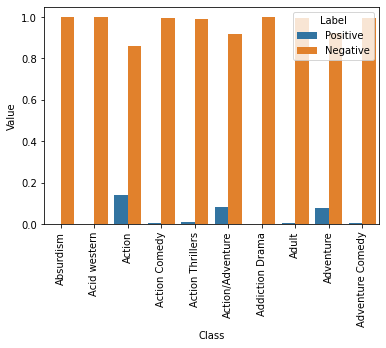

In [ ]:
data = pd.DataFrame({"Class": labels[:10], "Label": "Positive", "Value": freq_pos[:10]})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg[:10])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

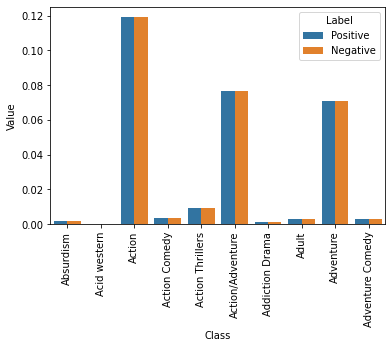

In [ ]:
data = pd.DataFrame({"Class": labels[:10], "Label": "Positive", "Value": pos_contribution[:10]})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution[:10])], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        loss_pos = -1. * tf.reduce_sum(K.mean(pos_weights * y_true * tf.math.log(y_pred+epsilon), axis=0))
        loss_neg = -1. * tf.reduce_sum(K.mean(neg_weights * (1 - y_true) * tf.math.log(1-y_pred+epsilon), axis=0))
        return loss_pos+loss_neg
    
        ### END CODE HERE ###
    return weighted_loss

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_for_sequence_cla ((None, 363),)       67232619    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
activation_16 (Activation)      (1, None, 363)       0           tf_distil_bert_for_seq

In [ ]:
opt = tfa.optimizers.RectifiedAdam(
    lr=5e-5,
    total_steps=200,
    warmup_proportion=0.4,
    min_lr=3e-5,
)

ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)

model.compile(optimizer=ranger, loss=get_weighted_loss(pos_weights, neg_weights), metrics=['acc', tf.keras.metrics.AUC()]) 

In [ ]:
def map_example_to_dict(input_ids, attention_masks, label):
  return {
      'input_token': input_ids,
      # "token_type_ids": token_type_ids,
      'masked_token': attention_masks,
  }, label

def encode_examples(texts, labels):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for text, label in zip(texts,labels):
    bert_input = tokenizer([text] , padding='max_length', truncation=True, stride=50, return_overflowing_tokens=True)
    input_ids_list.extend(bert_input['input_ids'])
    # token_type_ids_list.extend(bert_input['token_type_ids'])
    attention_mask_list.extend(bert_input['attention_mask'])
    label = list(np.float_(label))
    label_list.extend([label]*len(bert_input['input_ids']))


    
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list)).map(map_example_to_dict)

In [ ]:
batch_size=16
train = encode_examples(x_train,y_train)
train = train.cache().shuffle(len(y_train))
train = train.batch(batch_size)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for x,y in train.take(1):
  print(x)
  print(y)

{'input_token': <tf.Tensor: shape=(16, 512), dtype=int32, numpy=
array([[  101,  1996,  2143, ...,  3248,  2010,   102],
       [  101,  4110,  2011, ...,     0,     0,     0],
       [  101,  2128,  2893, ...,  1012,  5586,   102],
       ...,
       [  101,  1996,  2143, ...,  9790,  1010,   102],
       [  101,  1043, 11761, ...,     0,     0,     0],
       [  101,  1037,  7155, ...,     0,     0,     0]], dtype=int32)>, 'masked_token': <tf.Tensor: shape=(16, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(16, 363), dtype=float64)


In [ ]:
# def encode(x):
#   x= tokenizer(x.numpy().decode('utf8'), padding='max_length', truncation=True)
#   inp = x['input_ids']
#   # token_type = x['token_type_ids']
#   att_mask = x['attention_mask']
#   return inp,att_mask
#   # return inp,token_type,att_mask

In [ ]:
# def tf_encode(x,y):
#    i, a = tf.py_function(func = encode, inp = [x], Tout=[tf.int32,tf.int32])
#    y = tf.cast(y, dtype='float32')
#    return {'input_token':i, 'masked_token':a},y

#   #  return {'input_ids':i, 'token_type_ids':t, 'attention_mask':a},y

In [ ]:
# batch_size=16
# train = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), tf.constant(y_train)))
# train = train.map(tf_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train = train.cache().shuffle(len(y_train))
# train = train.batch(batch_size)
# train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
example_input_batch, example_target_batch = next(iter(train))

In [ ]:
def trial(tokenizer, inputs, l, ind):
  print('ids')
  print(inputs['input_token'][ind])
  print('mask')
  print(inputs['masked_token'][ind])
  print('words')
  for t in inputs['input_token'][ind]:
    if t!=0:
      print(tokenizer.convert_ids_to_tokens([t.numpy()]))
  print(gen_tokenizer.convert_tokens_to_string(gen_tokenizer.convert_ids_to_tokens(inputs['input_token'][ind].numpy())))
  print('label')
  print(labels[np.where(l[ind]==1)[0]])

In [ ]:
trial(tokenizer,example_input_batch, example_target_batch,-1)

ids
tf.Tensor(
[  101  1999  2494  1010  1996  8956  3082  1011  3384  2316  9353  8180
 19570 19513  2050  2020  1996  3395  1997  1037  3580  2932  3720  1012
  2007  1996  2932  1005  1055  2393  1010  2027  2020  2583  2000  2754
  1037  5271  1011  2041  2265  1999  2384  2750  1996  3522 15068 16643
  3070  1997 24111 16543  1012 16587  2013  3580  2513  2000  5712  1999
  2294  2000  2650  2091  1996  2316  1012  2588  2037  2709  2027  3603
  1996 20889  1997  2331  1998  6215  1010  2164  2128 26560  7741  4835
  3908  2011  9767  1012 27467  2094  7636  2007  1996  2316  2372  4473
  2019 12369  2046  1037  4942  2930  1997  2554  9561  2098  1999  2137
  3769  3226  1998  1996 17601  2023 17771  1012  3082  3384  1999 13952
 14841  4246   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0

In [ ]:
# test = tf.data.Dataset.from_tensor_slices((tf.constant(x_test),tf.constant(y_test))).shuffle(len(y_test))

# test = test.map(tf_encode,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

batch_size=16
test = encode_examples(x_test,y_test)
test = test.batch(batch_size)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/genre_pred_new.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
callbacks_list = [checkpoint]


In [58]:
model.fit(train, epochs = 4, validation_data=test, callbacks=callbacks_list)  #loss: 2.3813 - acc: 0.2479 - auc: 0.9493 - val_loss: 2.4897 - val_acc: 0.2416 - val_auc: 0.9449

Epoch 1/4
3333/3333 [==============================] - ETA: 0s - loss: 3.4736 - acc: 0.1873 - auc: 0.8850
Epoch 00001: val_loss improved from inf to 2.87889, saving model to /content/drive/My Drive/genre_pred_new.hdf5
3333/3333 [==============================] - 3488s 1s/step - loss: 3.4736 - acc: 0.1873 - auc: 0.8850 - val_loss: 2.8789 - val_acc: 0.2389 - val_auc: 0.9285
Epoch 2/4
3333/3333 [==============================] - ETA: 0s - loss: 2.6708 - acc: 0.2194 - auc: 0.9367
Epoch 00002: val_loss improved from 2.87889 to 2.64322, saving model to /content/drive/My Drive/genre_pred_new.hdf5
3333/3333 [==============================] - 3491s 1s/step - loss: 2.6708 - acc: 0.2194 - auc: 0.9367 - val_loss: 2.6432 - val_acc: 0.2152 - val_auc: 0.9366
Epoch 3/4
3333/3333 [==============================] - ETA: 0s - loss: 2.3522 - acc: 0.2239 - auc: 0.9490
Epoch 00003: val_loss improved from 2.64322 to 2.57772, saving model to /content/drive/My Drive/genre_pred_new.hdf5
3333/3333 [=============

In [59]:
model.load_weights('/content/drive/My Drive/genre_pred_new.hdf5')

In [106]:
def predict_genre(text):
  genres=[]
  inps= tokenizer([text], padding='max_length', truncation=True, stride=50, return_overflowing_tokens=True)
  inp_ids = inps['input_ids']
  # token_type = x['token_type_ids']
  att_mask = inps['attention_mask']

  inp = {'input_token': tf.constant(inp_ids), 'masked_token': tf.constant(att_mask)}
  preds = model(inp)
  # preds = np.squeeze(preds)
  for pred in preds:
    ids = pred > 0.86
    genres.extend(labels[ids])
  return set(genres)

In [107]:
predict_genre("After witnessing his parents' death, Bruce learns the art of fighting to confront injustice. When he returns to Gotham as Batman, he must stop a secret society that intends to destroy the city.")

{'Action',
 'Action/Adventure',
 'Martial Arts Film',
 'Superhero',
 'Superhero movie'}

In [108]:
predict_genre("A detective hunts down a young and successful man who runs a crime syndicate.")

{'Crime Drama',
 'Crime Fiction',
 'Crime Thriller',
 'Detective',
 'Detective fiction',
 'Film noir',
 'Gangster Film',
 'Heist',
 'Mystery',
 'Thriller'}

In [109]:
predict_genre("Tori and Kyle find a baby boy in a spaceship and adopt him as their own child, Brandon. However, after turning 12, Brandon learns that he has superpowers and begins to use them for sinister purposes.")

{'Alien Film', 'Horror', 'Science Fiction', 'Teen'}

In [110]:
predict_genre("Seok-woo and his daughter are on a train to Busan on the latter's birthday to see his wife. However, the journey turns into a nightmare when they are trapped amidst a zombie outbreak in South Korea.")

{'B-movie', 'Creature Film', 'Haunted House Film', 'Horror', 'Zombie Film'}

In [111]:
predict_genre("On the margins of Tokyo, a dysfunctional band of outsiders is united by fierce loyalty and a penchant for petty theft. When the young son is arrested, secrets are exposed that upend their tenuous, below-the-radar existence.")

{'Japanese Movies', 'World cinema'}

In [112]:
text ="""Fund manager Seok-woo is a cynical workaholic and divorced father. His little daughter Su-an wants to spend her birthday with her mother in Busan. Seok-woo sees a video of Su-an attempting to sing "Aloha ʻOe" at her singing recital and succumbing to stage fright as a result of his absence. Overcome with guilt, he decides to indulge Su-an's wish. They board the KTX 101 at Seoul Station, en route to Busan. Other passengers include working-class man Sang-hwa and his pregnant wife Seong-kyeong, selfish COO Yon-suk, a high school baseball team, including Yong-guk and his cheerleader girlfriend Jin-hee, elderly sisters In-gil and Jong-gil, and a homeless stowaway. As the train departs, an infected woman boards, becomes a zombie and attacks a train attendant. The infection spreads rapidly throughout the train. Seok-woo learns that the zombie plague started at a factory connected to his business, and selfishly plans to use his connections to get to safety. The group escapes to another car and locks the doors. Reports make it known that an epidemic is spreading across the country. After the train stops at Daejeon Station, where an army post is rumored to be housed the surviving passengers find that all the personnel stationed there are infected by the virus, and Seok-woo figures it out himself when a soldier is completely overrun by the infected. The surviving passengers manage to make it back on the train, but Sang-hwa, Seok-woo, Yong-guk, and two surviving baseball players get stuck closing the door. Su-an, Seong-kyeong, In-gil, and the homeless man manage to get on, but they find out that they are in the crosshairs of zombies, and they hide inside a bathroom. Meanwhile. Seok-woo's team manages to close the door, but the glass door shatters, and in the process of running, only Yong-guk, Sang-hwa, and Seok-woo manage to get on the train, with the two baseball players becoming infected. The military establishes a quarantine zone near Busan, and the conductor heads the train there. Seok-woo, Sang-hwa and Yong-guk - who have become separated from their loved ones in a different car, use Yong-guk's baseball bat, riot gear, and hand to hand combat to fight their way to them through the zombies. Once regrouped, they struggle through the horde to the front car, where the rest of the passengers are sheltered. However, the homeless man steps on a soda can, alerting the zombies to their location, and Seok-woo and Sang-hwa attempt to hold off the zombies, but Sang-hwa is bitten. At Yon-suk's instigation, the passengers prevent the survivors from entering, fearing that they are infected. Sang-hwa sacrifices himself to give the others time to enter the car by force by allowing all the zombies to eat him. Yon-suk and the passengers demand that the survivors isolate themselves in the vestibule. However, Jong-gil – disgusted at the passengers' selfishness and despairing the loss of her sister, who has become a zombie – allows the zombies to enter and kill them all. Ironically, because the passengers had forced Seok-woo's group to isolate, his group remains safe. Yon-suk also escapes by hiding in the bathroom with a train attendant, with the survivors breaking off into groups, with Seok-woo, Su-an, Seong-kyeong, Jin-hee, Yong-guk, and the homeless man in one group, and Yon-suk, and the final train attendant in the other A blocked track at East Daegu train station forces the survivors to stop and search for another train. Yon-suk pushes Jin-hee, the train captain, and the train attendant to the zombies to save himself and Jin-hee is bitten. Heartbroken, Yong-guk stays with Jin-hee until she turns and kills him. Meanwhile, a flaming locomotive derails and the survivors are trapped under a train full of zombies. As the zombies drop by breaking the windows, the homeless man sacrifices himself so that Seok-woo has time to save Su-an and Seong-kyeong through a small hole under the derailed train. Realizing that there is a locomotive that still works, Seok-woo, Seong-kyeong, and Su-an narrowly avoid the zombies, and the three board the working locomotive and encounter Yon-suk, who is on the verge of turning into a zombie. Seok-woo manages to throw him off the train, but is bitten in the process. He teaches Seong-kyeong how to operate the train, and says goodbye to his sobbing daughter, throwing himself off the train before he turns. Due to another train blockage, Su-an and Seong-kyeong stop at a tunnel. They continue following the tracks on foot. Snipers stationed on the other side prepare to shoot at what they believe to be zombies. Upon hearing Su-an sobbing and singing "Aloha ʻOe" for her father, they lower their weapons, realizing the pair are human, as they help get them to safety."""

In [113]:
predict_genre(text)

{'B-movie', 'Creature Film', 'Horror', 'Horror Comedy', 'Zombie Film'}

In [114]:
text1="""Detective Seo Do-cheol is tough and merciless when it comes to crime. But while investigating a high-profile case, Seo finds out that arrogant young millionaire Jo Tae-oh — the third-generation heir to powerful conglomerate Sinjin Group — is pulling some strings behind the scenes. However, no matter how rigorously Seo's team pursues him, Jo always escapes with the help of his wealth and connections."""

In [115]:
predict_genre(text1)

{'Crime Fiction', 'Crime Thriller', 'Gangster Film', 'Thriller'}

In [116]:
detective_conan = """While sorting mail at Dr. Agasa's house, Conan finds an invitation addressed to Jimmy from Leo Joel, a famous architect. Jimmy calls Rachel using his voice-changing bowtie and asks her to go in his place. Rachel agrees, on the condition that Jimmy goes to a movie with her on Saturday. On Saturday morning, Conan receives a call from a strange man, who challenges Jimmy to a game. Conan accepts the challenge, and the mystery caller gives him clues leading to bombs hidden all over Tokyo. Conan finds and destroys every one. Because of the locations of the bombs - near structures designed by Joel - Conan deduces that the bomber is Joel, who planned to destroy his "inferior" works and create a perfect new building. Upon his arrest, Joel reveals the location for his final bombs: Beika City Building, the location of Jimmy and Rachel's date. The bombs explode and seal the entrances and exits, trapping Rachel and others inside. Conan makes his way through the collapsing building, but a warped door blocks him off from Rachel. Using his tie and cell phone, he calls Rachel and asks her to look for the bomb. Rachel finds it in a large shopping bag. To disarm the bomb, Jimmy tells Rachel which wires to cut. However, Joel made two extra wires, one red, one blue. One of them is booby-trapped, but Jimmy has no idea which. Jimmy tells Rachel to cut either one. As the rescue team arrives and carries him away, Jimmy realizes that Joel knew that Rachel's favorite color was red and booby-trapped the red one. In the last few minutes, Rachel makes a desperate decision and cuts the blue wire because the red wire represents the red string of fate between Jimmy and herself."""
predict_genre(detective_conan)

{'Action',
 'Animation',
 'Anime',
 'Japanese Movies',
 'Science Fiction',
 'Superhero movie'}

In [117]:
isawthedevil = """On a given night, a school-bus driver named Jang Kyung-chul encounters a pregnant woman named Jang Joo-yun, and offers to fix her flat tire. After beating her unconscious, Kyung-chul executes her with a makeshift guillotine at his home, and scatters the body-parts into a local stream. When a boy discovers one of Joo-yun's ears, the police arrive en masse to conduct a search, led by Section Chief Oh and Squad Chief Jang, the latter being Joo-yun's devastated father. The victim's fiance, Kim Soo-hyun, who is an agent of the National Intelligence Service, is also present and vows to take revenge against the murderer. Soo-hyun learns of the four suspects from Squad Chief Jang, and proceeds to privately torture and interrogate two of them. Upon searching the home of Kyung-chul, the third suspect, Soo-hyun finds Joo-yun's engagement-ring, proving that Kyung-chul was the perpetrator. A short time later, as Kyung-chul brings a schoolgirl home and sexually assaults her, Soo-hyun beats him unconscious. Rather than killing Kyung-chul and being done with it, Soo-hyun decides to shove a GPS tracker down his throat, allowing him to see Kyung-chul's location in real-time, and to listen to his conversations. Waking up injured, Kyung-chul walks along the road and is offered a ride by a taxi already containing one passenger. Upon getting in, and correctly guessing that the driver and passenger are, in fact, two bandits intending to rob and murder him, he strikes out preemptively and kills them both, afterward finding the body of the real taxi-driver in the trunk. Kyung-chul throws out all three bodies, and drives to a small town where he sexually assaults a nurse. Soo-hyun arrives to subdue him, and slashes his Achilles tendon before releasing him once more. Kyung-chul visits the home of his friend Tae-joo, a murderer and eater of human flesh. After explaining his situation to Tae-joo, the latter remarks that whoever is after him must be the relative of one of his victims. Soo-hyun arrives and incapacitates both murderers along with Tae-joo's girlfriend. The next day, Tae-joo and Se-jung, still unconscious, are arrested by the police and sent to the hospital. Soo-hyun's trusted subordinate arranges for Soo-hyun and Kyung-chul to evade the police and receive treatment for their wounds at a separate facility. The barely conscious Kyung-chul hears Soo-hyun and the subordinate talking about the transmitter. Soo-hyun releases Kyung-chul again, but the latter outsmarts Soo-hyun by removing the transmitter this time and dashing away, but not before slashing the throat of a pharmacist. Soo-hyun enters Tae-joo's hospital room to question him, and learns too late that Kyung-chul is going after Squad Chief Jang and his other daughter Jang Se-yun. Kyung-chul arrives at the house of Squad Chief Jang, and proceeds to brutally assault Squad Chief Jang and Jang Se-yun, possibly killing them. Shortly after, Kyung-chul attempts to avoid Soo-hyun's revenge by surrendering to the police. However, Soo-hyun drives by and kidnaps Kyung-chul right in front of the police's eyes. Taking him to the earlier warehouse, Soo-hyun tortures him and places him under the makeshift guillotine. Kyung-chul's son and elderly parents, whom he had abandoned some time ago, are told of his whereabouts and try to visit him. Upon opening the door, the guillotine is dropped and Kyung-chul's head rolls to their feet. With Kyung-chul finally dead, Soo-hyun, who was listening through the transmitter some distance away, begins to cry."""
predict_genre(isawthedevil)

{'Crime Fiction', 'Crime Thriller', 'Horror', 'Thriller', 'World cinema'}

In [118]:
raataakelihai = """The film starts with a car being followed by a truck and truck hits the car and kills both the driver and the lady. Killer takes the bodies to a factory and burns them with the acid but accidentally acid got spilled on his hand. Five years Later, Inspector Jatil Yadav after attending the wedding of his colleague Narendra Singh gets called up by the SSP to investigate a murder of Raghuveer Singh who gets murdered by his own gun on his wedding night. He is introduced to family by Ramesh Chauhan, brother in law of Raghuveer Singh's first wife. Members of the family are Karuna Singh Daughter of Raghuveer Singh, Karan son of Raghuveer Singh, Chunni maid of the house, Pramila Singh wife of Raghuveer Singh's Brother, Vasudha and Vikram daughter and son of Pramila, Ravi Sisodia husband of Karuna and Radha wife of Raghuveer Singh. Starting Interrogation Vikram told he was the first one to see the dead body, he went to drop his fiancee daughter of MLA Munna Raja around 9:30 and came back around 11:15 and then went with family to temple at 12:30 after which he saw his uncle dead, there was baraat crossing in-front of the house at 10:30. He also found about back stairs which connects directly to water tank, During investigation with Radha, she remembers something and gives the chit to Chunni who gives it to Jatil, on chit the address of Radha is written and he remembers that he saved Radha five years earlier, when she attempted suicide on a train. Further during investigation he finds that Raghuveer's first wife was killed during robbery when she was coming back from Gwalior, his son Karan has also been apprehended with drugs once. Next Day, during investigation, Jatil finds the erotic magazines in Raghuveer's cupboard and some photos of women and plastic bead below the bed. He also finds that Radha was sold by her father and one of the photos is of Radha which he found earlier. Radha further refrains from telling anything to him. Later, Munna Raja comes in after Ravi calls him. Jatil also sees an old lady who was earlier a maid of house and her son was driver when Raghuveer's first wife was returning from Gwalior and she is grandmother of Chunni. Forensics tell them he was murdered between 10 and 12 with his own gun and blunt marks were due to because he was hit by butt of the gun.Phone records show that Vikram received phone call from his uncle at 11:30 and many phone calls from an unknown number which is of Radha. No fingerprints were found on gun as well as from the Raghuveer's phone. During interrogation with Chunni he finds she was the one who took the lamp up to Raghuveer's room and came back with the lamp which broke down on the stairs. She also refrains from telling anything but she tells he couldn't even see her father who died in that road accident and case got closed. Jatil starts investigating the death of Raghuveer's first wife and her driver, and finds that another city's police had reported a similar car and it was filed as hit and run case, leading him to tannery in Jajmau; which is run by a butcher but originally owned by Munna Raja.Further investigation with family reveals that Karuna doesn't like her aunt and her cousin's interference and later Jatil finds a medical report and in the morning Chunni is found dead near the back stairs. He later fights with Narendra his colleague and openly tells the SSP that he will find the truth. Later he is attacked by the goons and calls Narendra for help but he ignores him but he tells him that he is going to arrest Radha, he immediately informs Radha to run but before she can run away Ravi chases her and she locks herself in a room but Jatil comes in time to take her away but goons continue to chase them, they catch the train and unknown to them one of the goons also catches the train. later in the night Radha wakes up to see Jatil missing she takes her knife with her, she finds Jatil being attacked by the Butcher working for Munna Raja, Both overpower him to throw him out of the train. they both reach Raghuveer's Gwalior farmhouse. During this Narendra singh is investigating the murder of Chunni and forensics tells him about the dead skin found in her fingernails leading to man with burnt skin, he makes the report and goes to SSP but he sees the man having fingernail marks on burnt hand in the office of SSP with Munna Raja. He goes to Chunni's grandmother and shows her the photo of the man. Also he informs him about all of this to Jatil, but in the mean time he finds a dupatta in Radha's bag having the same bead he found earlier, he confronts her that she was in fact in the room and she lied, she confesses that she and vikram had an affair and planned to elope with Vikram but he didn't as he was getting married to MLA's daughter, seeing this she got furious and called vikram to come and talk, he went back as soon he dropped his fiancee and parked the card and without anyone noticing took the back stairs and confronted Radha. As she going to enter the room to tell Raghuveer about the affair, lights went out, she tells the truth and Chunni comes upstairs with the lamp, as electricity comes back they all find Raghuveer already dead, Vikram tells her to go downstairs and meanwhile Vikram tells Chunni to call on his cell from Raghuveer's phone. After this while coming back she drops the lamp on the stairs and Vikram takes the backstairs and by main gate he asks the women to come to go for the temple.Later Jatil calls SSP that he has made Radha surrender in another police station. He opens the medical report and finds the medical report under the name of Raghuveer's 1st wife and report was of abortion, and abortion was done one day before the accident. He enquires about it from her brother Ramesh who tells him that she was here with him as Karan caught Malaria but left all of a sudden to kanpur but when he asked on the phone he told he heard horns of the train but contradicting to this she was travelling by car. He also enquired the caretaker of the farmhouse who told that she ordered him to call whenever Raghuveer came with another woman. Investigating the farmhouse he finds the same erotic magazines, polaroid photos, polaroid camera and a badge of a boarding school. He visits the abortion clinic as well and watches the wedding video too. He comes to know that Radha is being taken by police under the bridge on the orders of SSP. As Radha is being taken by Narendra Singh under the bridge the same van comes who were chasing Jatil with the butcher in it, he comes out and inspects the van as he opens the van to take out Radha, Jatil who all along was accompanying her come out and attack resulting in cross-firing in which Radha gets injured but butcher escapes, as soon as butcher reaches his home Chunni's grandmother comes from back and throws oil onto him and burns him alive. In the climax, Radha comes with Jatil in the bungalow with everyone present he starts to tell the truth, He confronts Ravi first that he is one who gave drugs to Karan and later school caught him and Raghuveer bailed him out. It was in fact butcher who killed both Raghuveer's first wife and driver and burnt the bodies in the tannery on the orders of Munna Raja, she came to know about a woman Raghuveer brought in the farmhouse by the caretaker which came out to be Vasudha, Pramila's daughter. She was sexually abused many times by her uncle and expelled from school. On 16th Chunni filed a missing report for her father which later got closed and It was Vasudha who killed her uncle because she confronted him with the truth but he dismissed her claims but in rage she takes out the gun and kills him, later she took out her dupatta and put it in the Radha's bag and changed it which was noticed by Jatil in the wedding video. Mrs Raghuveer called Pramila and told the truth to her and she was going to go back to her brother's home but she asked her to come to back Kanpur by Pramila and in mean time Pramila called Munna Raja and told him to kill Mrs Raghuveer as she was afraid Mrs Raghuveer will take them out of their property and Munna Raja bought Radha from his father for Raghuveer for his sexual desires. She then forgives Raghuveer for everything. After being confronted with truth Pramila kills herself, during cremation Vasudha tells Jatil the truth. Jatil goes back to his normal life. He catches up with Radha's train and asks her to spend her life with him, which she happily accepts."""
predict_genre(raataakelihai)

{'Bollywood',
 'Musical',
 'Romance Film',
 'Romantic drama',
 'Tamil cinema',
 'Thriller',
 'Tollywood',
 'World cinema'}